In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pip install catboost

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [8]:
data = pd.read_csv('/content/drive/MyDrive/fetal_health.csv')

In [9]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [11]:
data.isna().sum().sum()

0

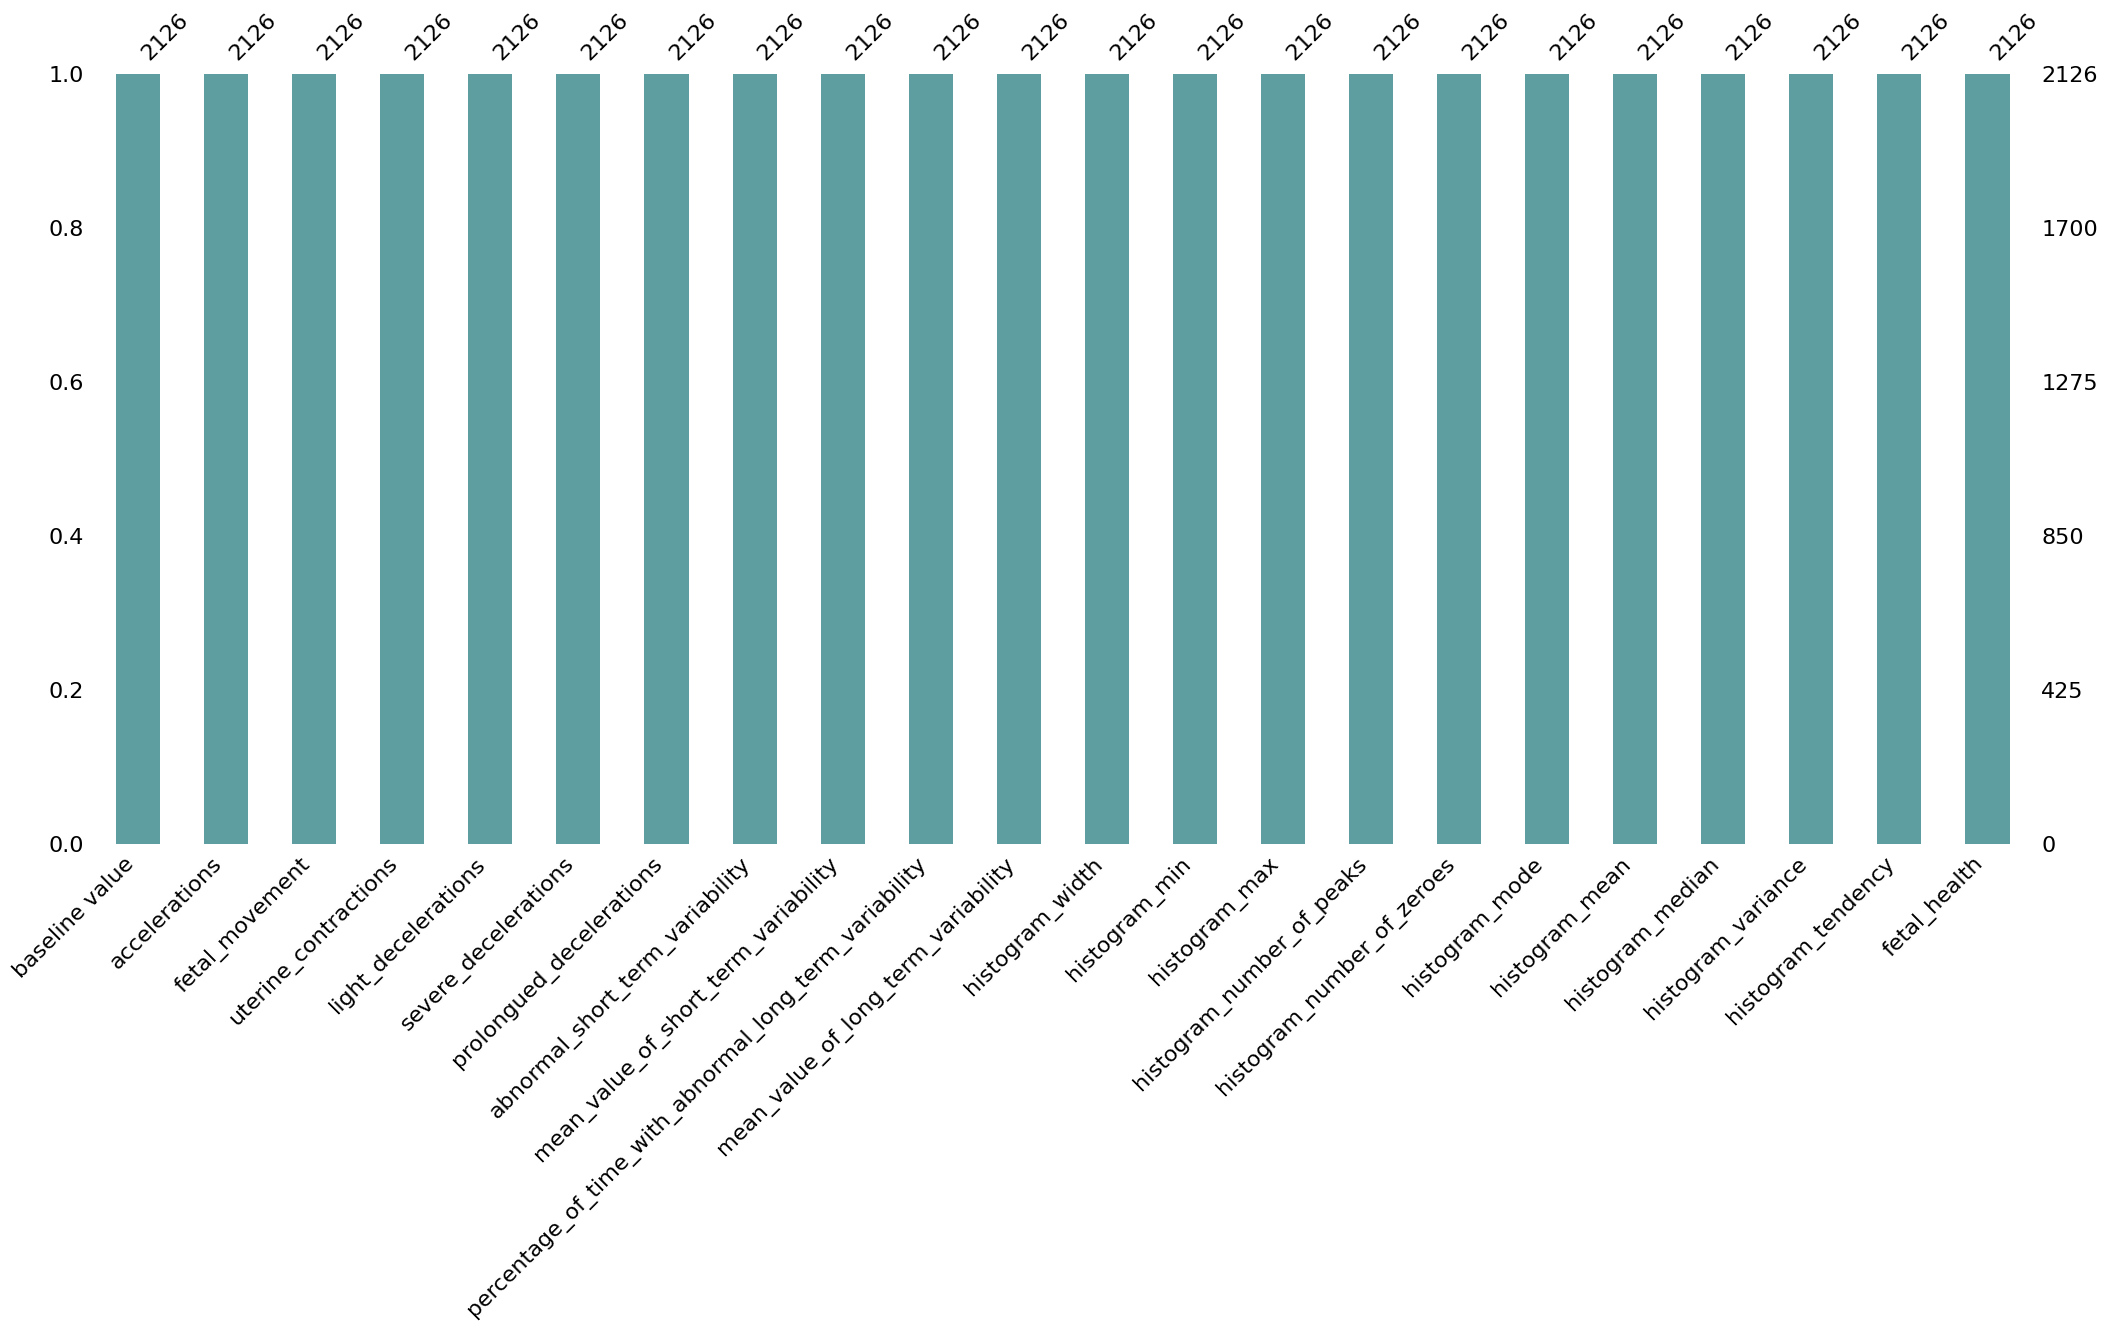

In [12]:
# Null count analysis
null_plot = msno.bar(data, color = "#5F9EA0")

In [13]:
eda_df = data.copy()

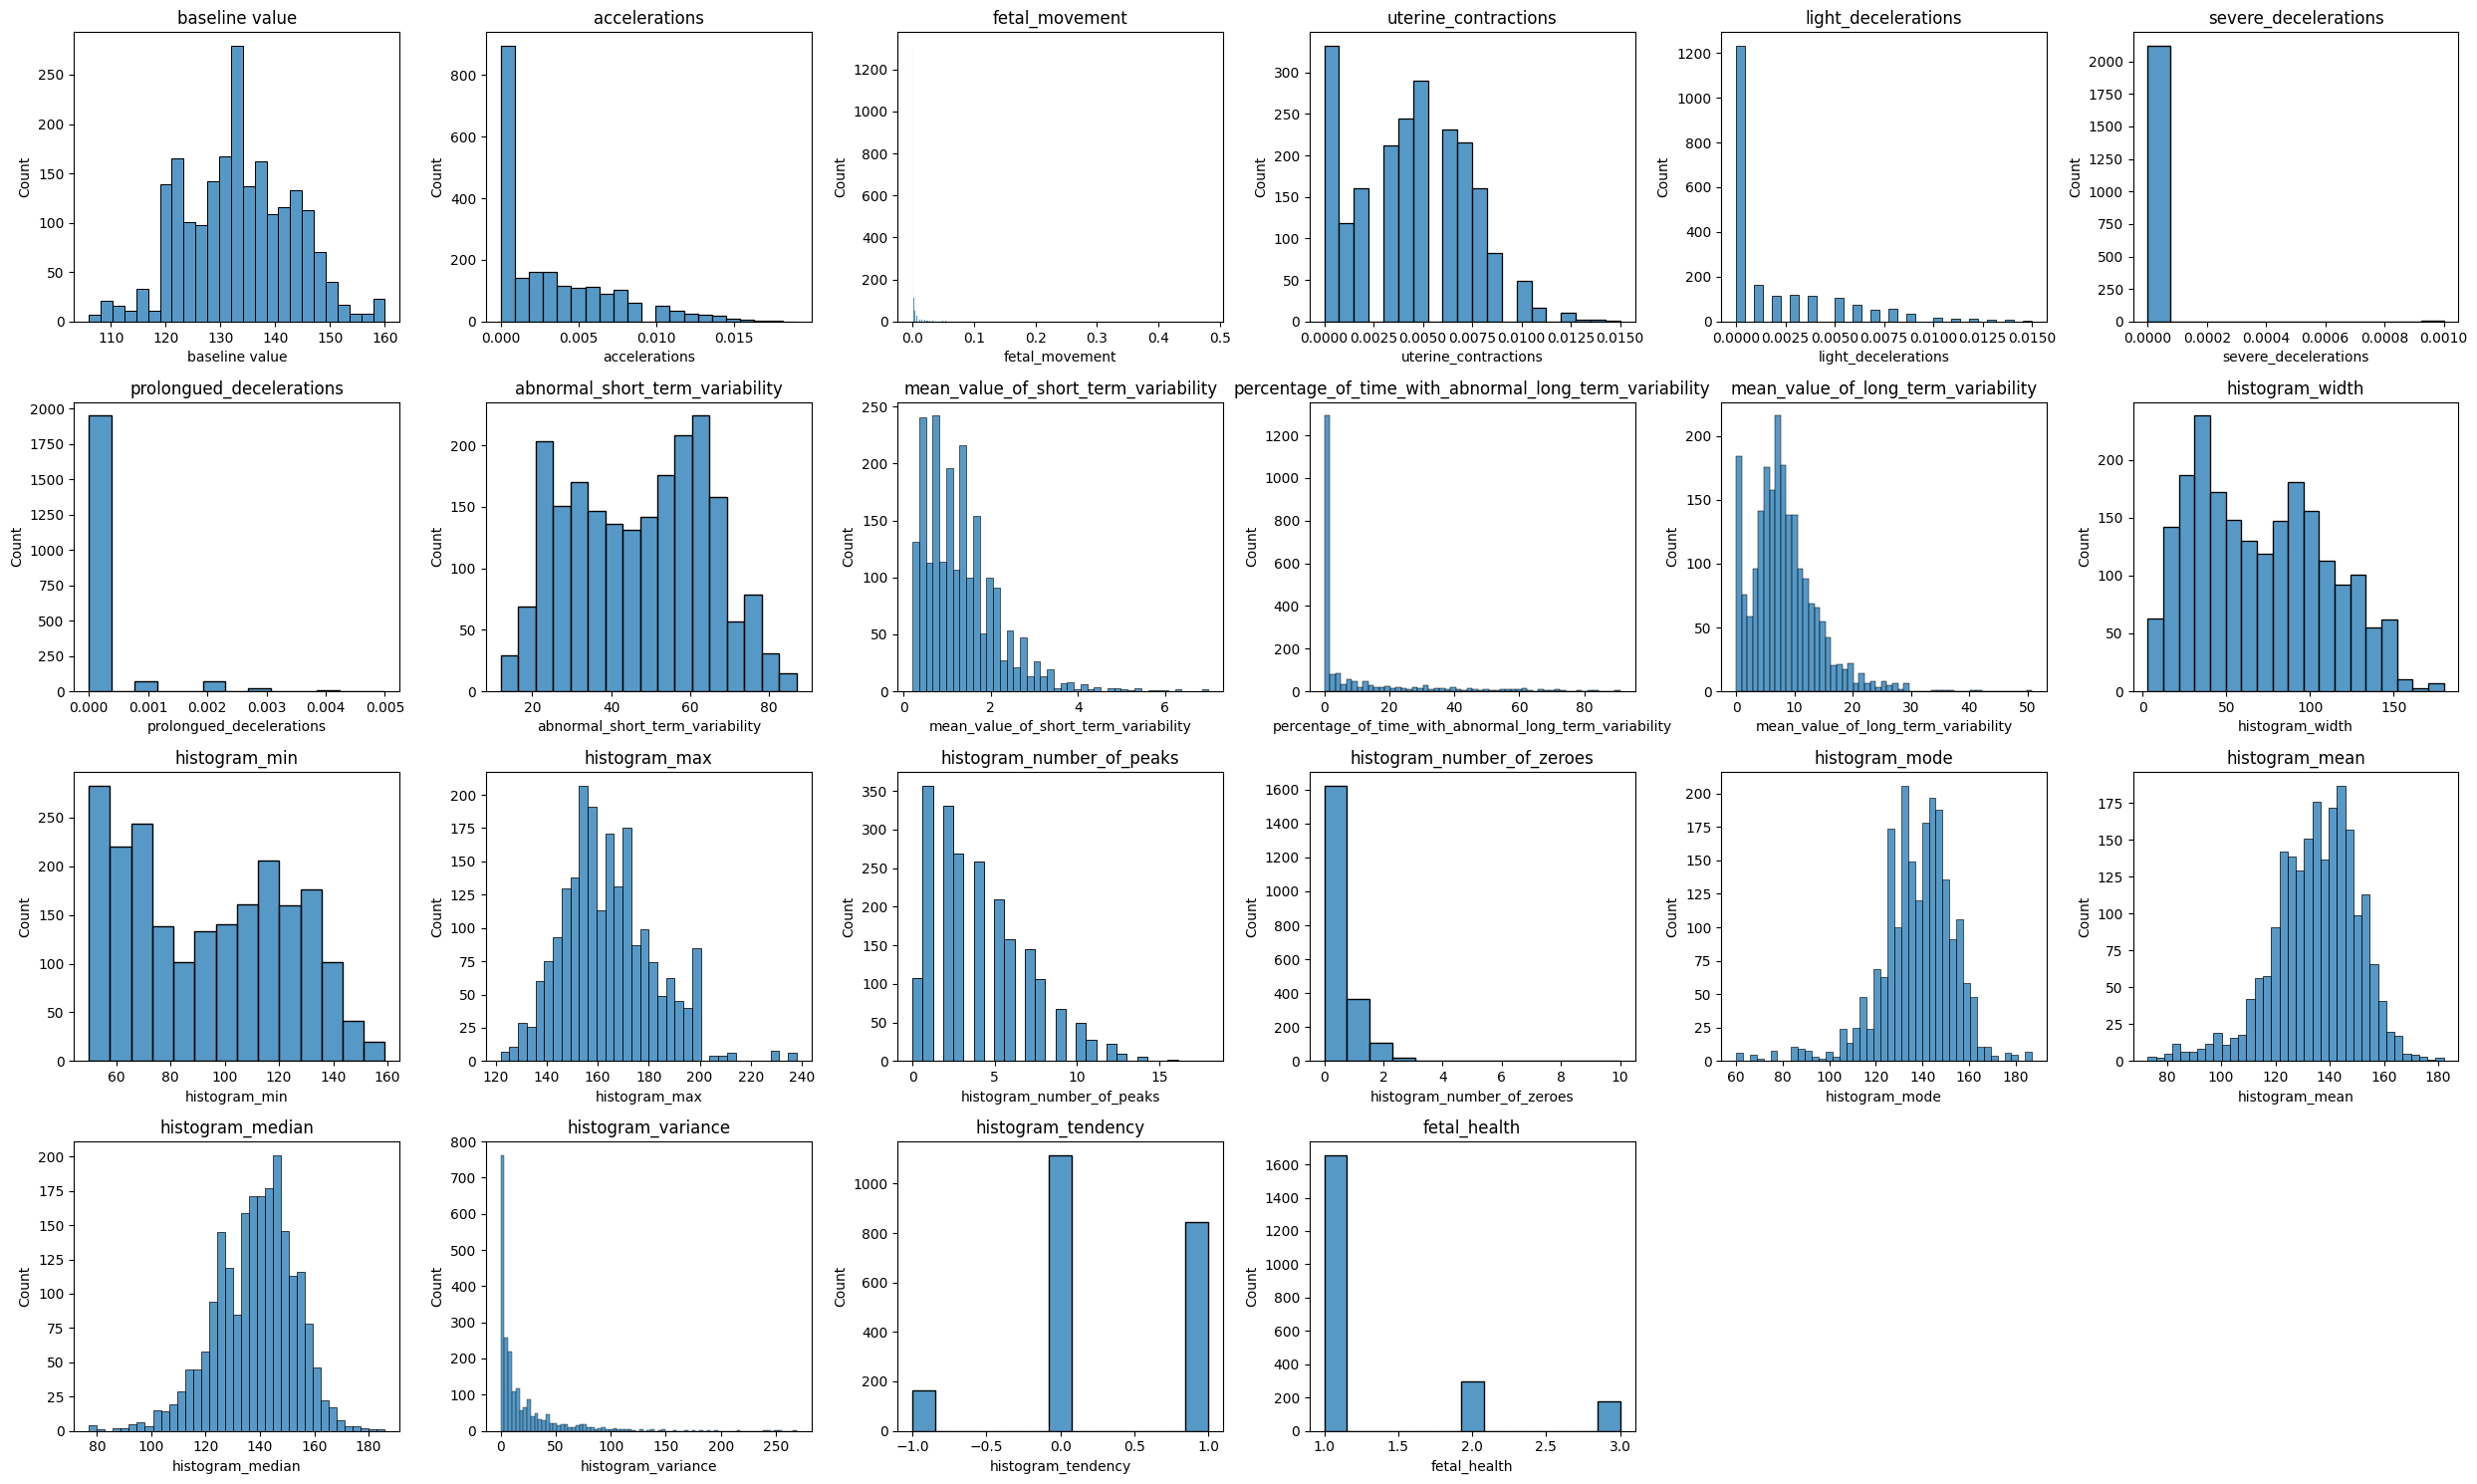

In [14]:
plt.figure(figsize=(25, 15))

for i, column in enumerate(eda_df.columns):
    plt.subplot(4, 6, i + 1)
    sns.histplot(data=eda_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

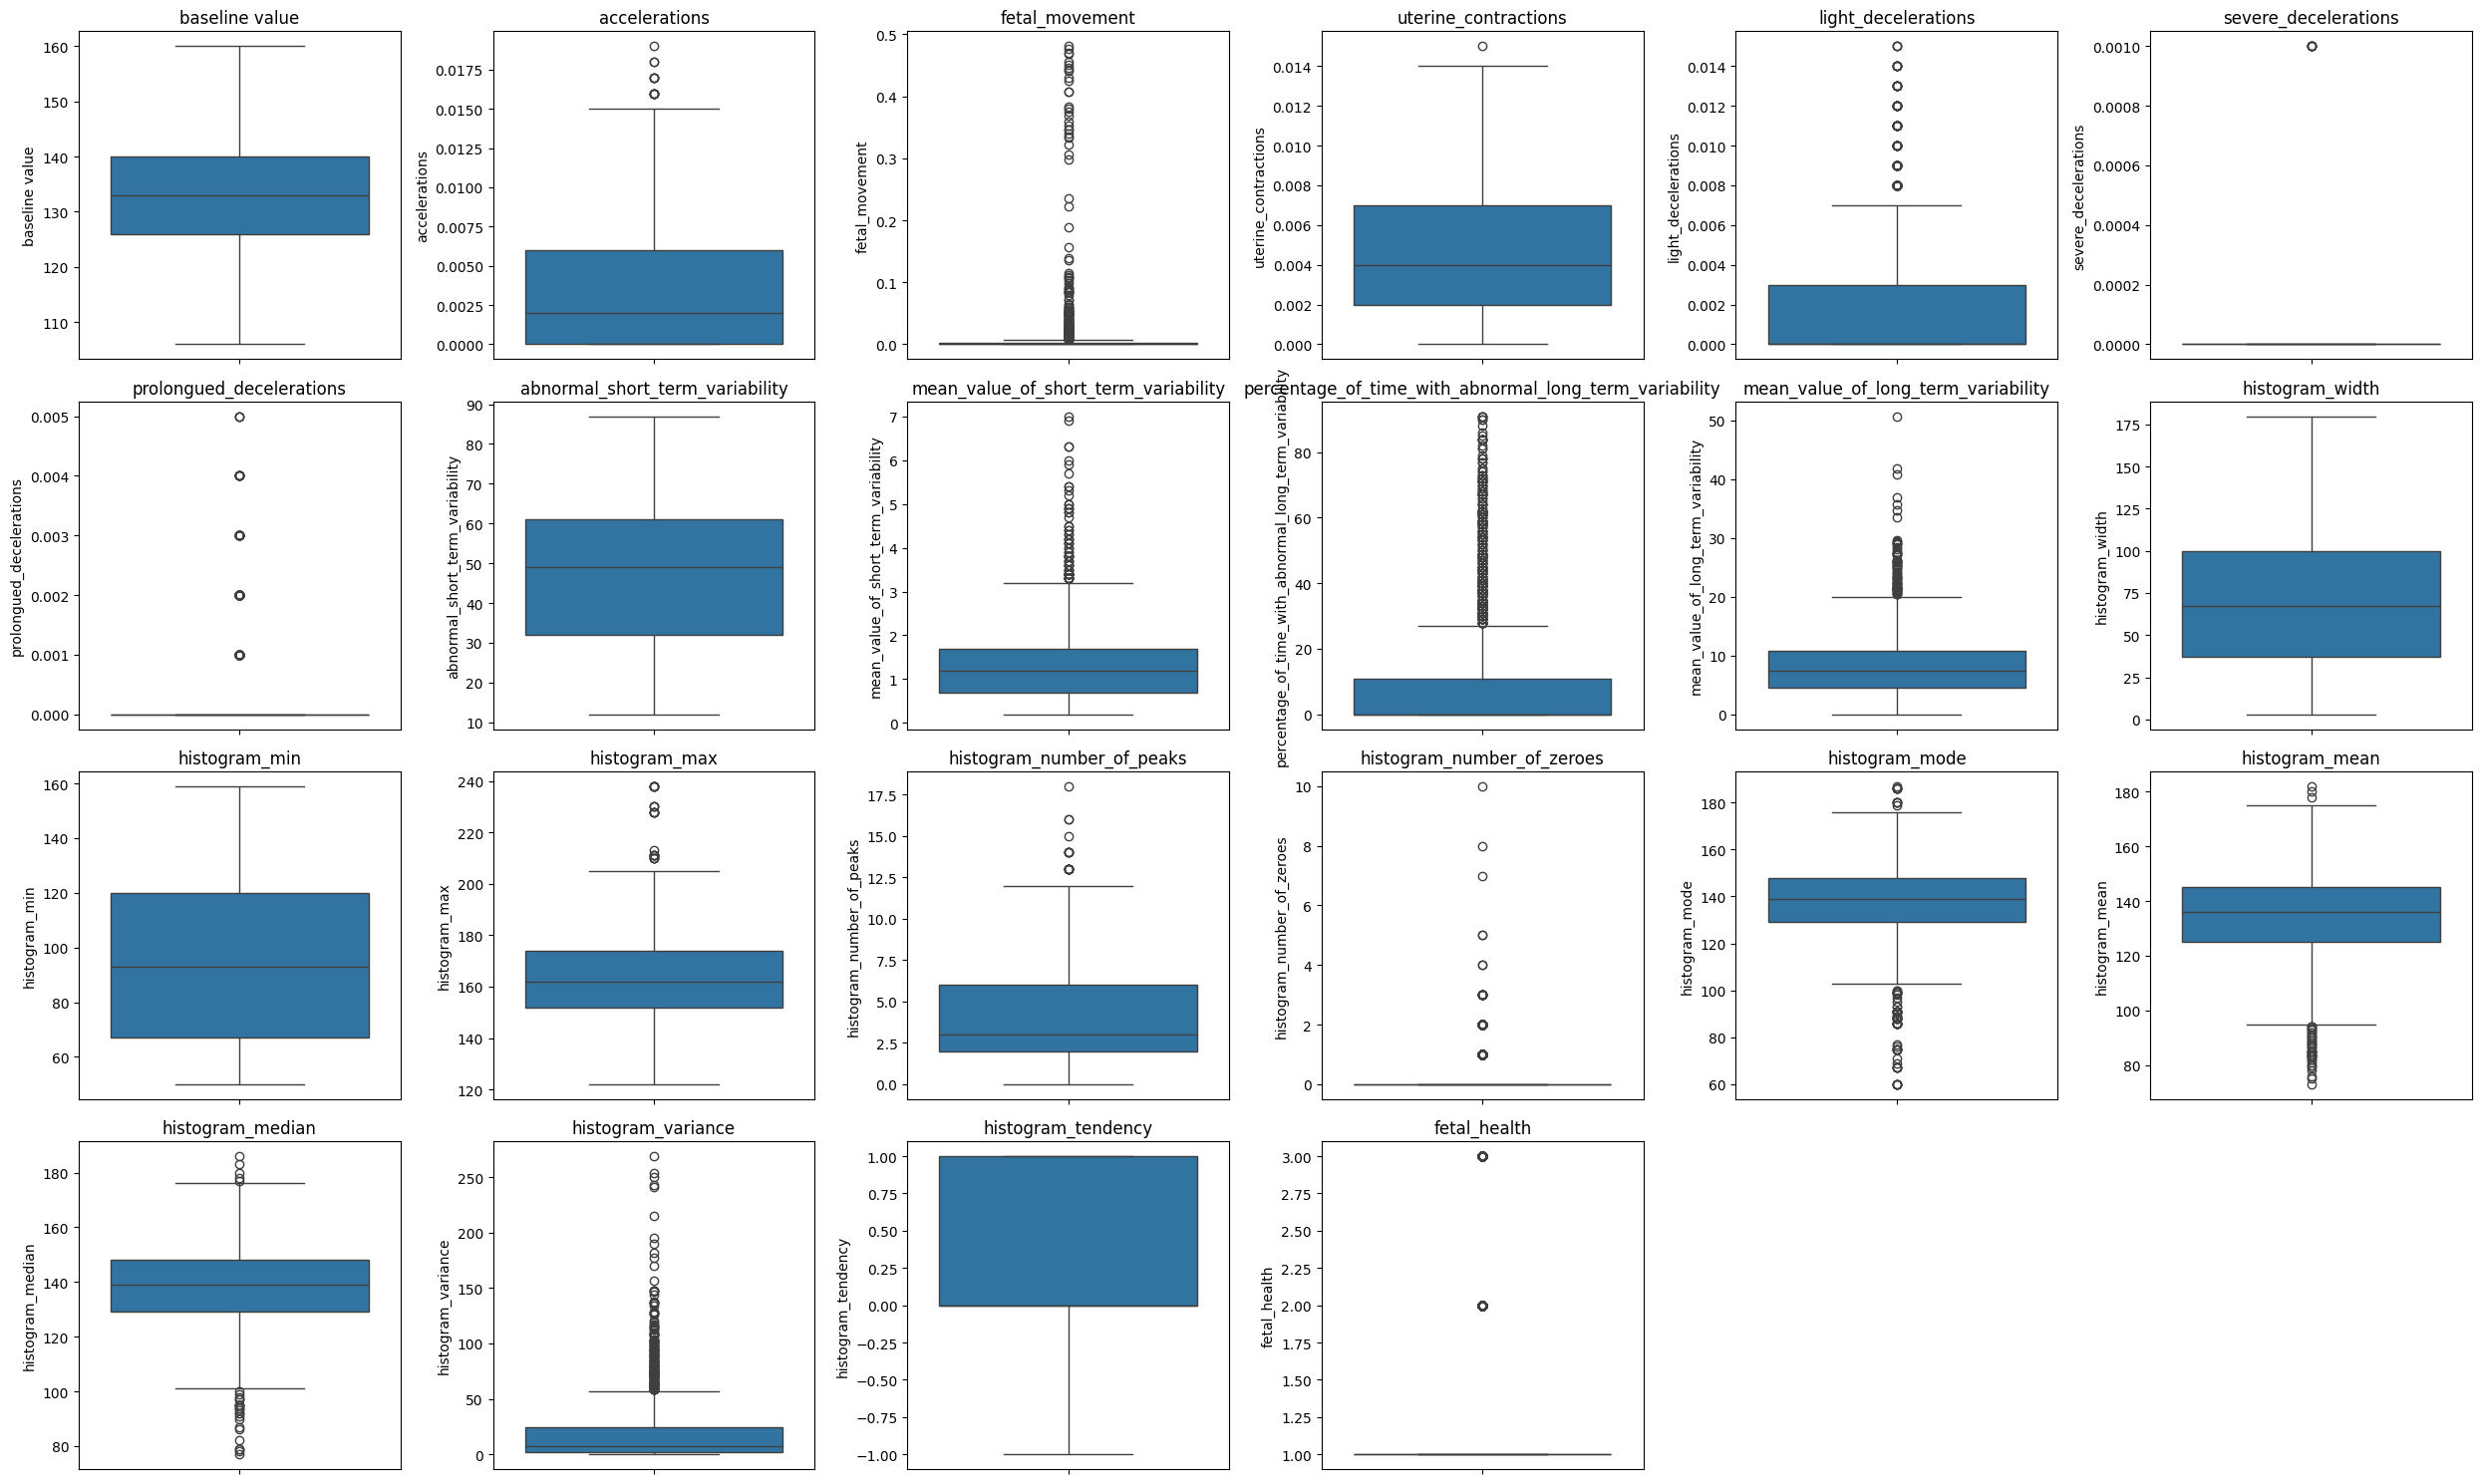

In [15]:
plt.figure(figsize=(25, 15))

for i, column in enumerate(eda_df.columns):
    plt.subplot(4, 6, i + 1)
    sns.boxplot(data=eda_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

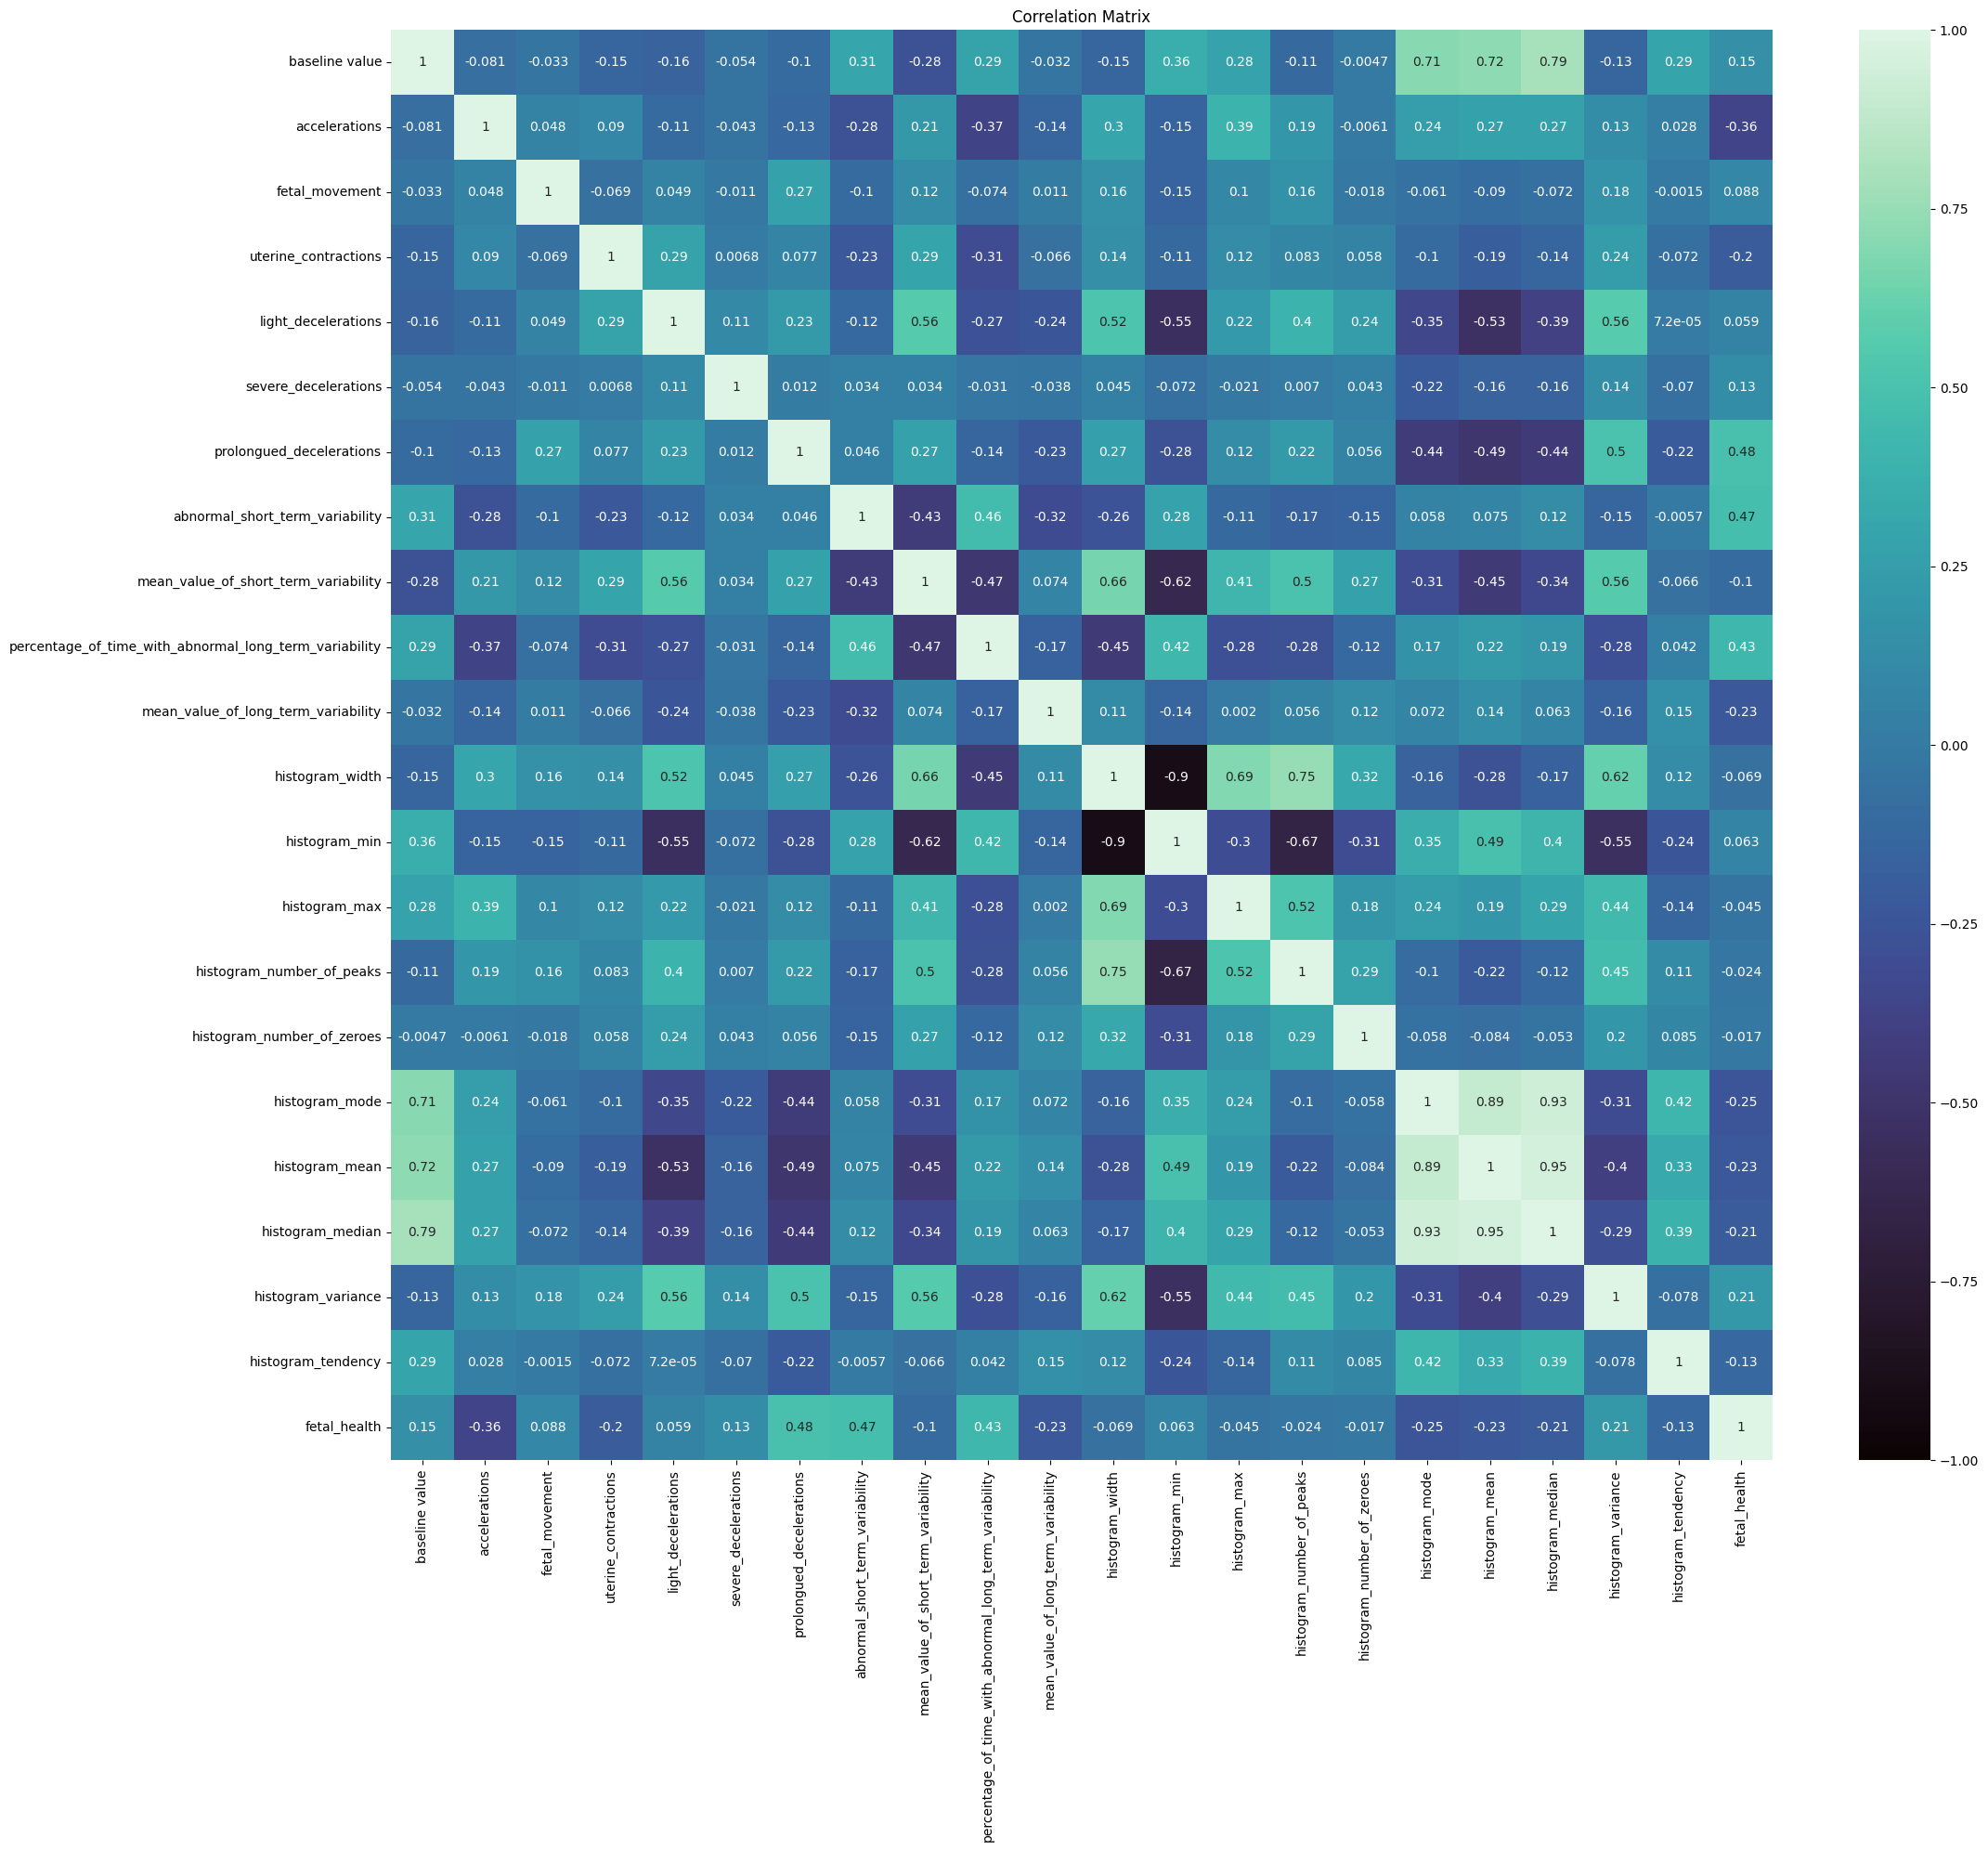

In [16]:
corr = eda_df.corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation Matrix")
plt.show()

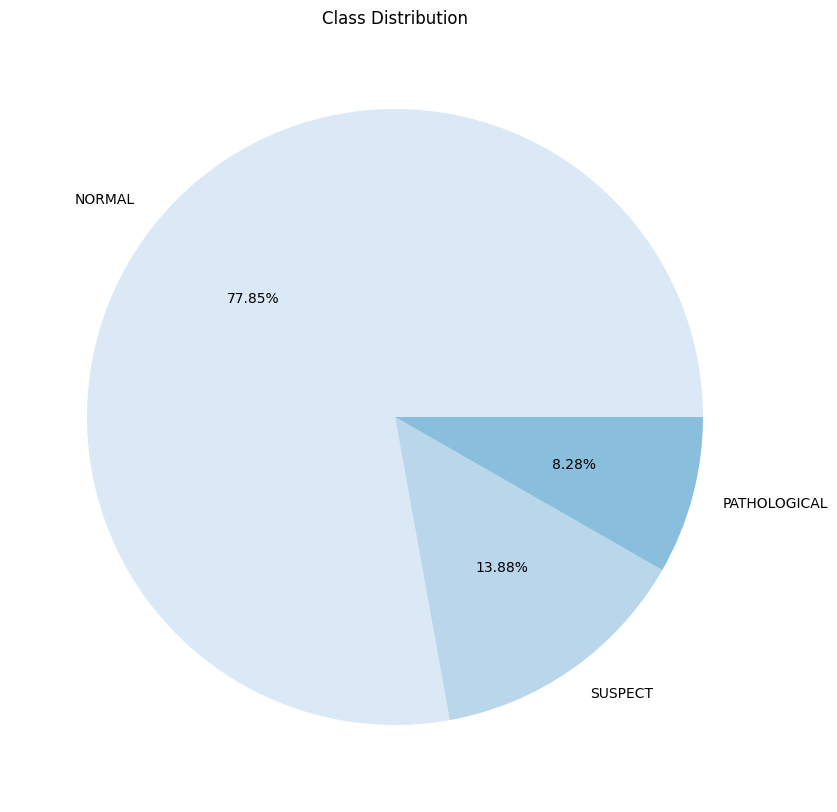

In [17]:
plt.figure(figsize=(10, 10))

plt.pie(
    eda_df['fetal_health'].value_counts(),
    autopct='%.2f%%',
    labels=["NORMAL", "SUSPECT", "PATHOLOGICAL"],
    colors=sns.color_palette('Blues')
)

plt.title("Class Distribution")
plt.show()

In [18]:
# Split df into X and y
df = data.copy()
y = df['fetal_health']
X = df.drop('fetal_health', axis=1)


In [19]:
# OverSampling
oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(X, y)

In [20]:
# Scale X
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_over)
X_scaled=pd.DataFrame(X_scaled,columns=X_over.columns)
X_scaled.shape

(4965, 21)

In [21]:
# PCA
pca=PCA(n_components=0.95) #0.95 here refers that the total variance explained by the components must be atleast 95%
X_pca_final=pca.fit_transform(X_scaled)
X_pca_final=pd.DataFrame(X_pca_final)
X_pca_final.shape

(4965, 13)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_final, y_over, shuffle=True, random_state=42, stratify = y_over)

In [24]:
# Cross Validation
cv_method = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [25]:
# params_knn = {"leaf_size": list(range(1,30)),
#               "n_neighbors": list(range(1,21)),
#               "p": [1,2]}
# GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(),
#                                 param_grid=params_knn,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_knn.fit(X_train, y_train)
# best_estimator_knn = GridSearchCV_knn.best_estimator_
# best_params_knn = GridSearchCV_knn.best_params_
# best_score_knn = GridSearchCV_knn.best_score_

In [26]:
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

<Axes: >

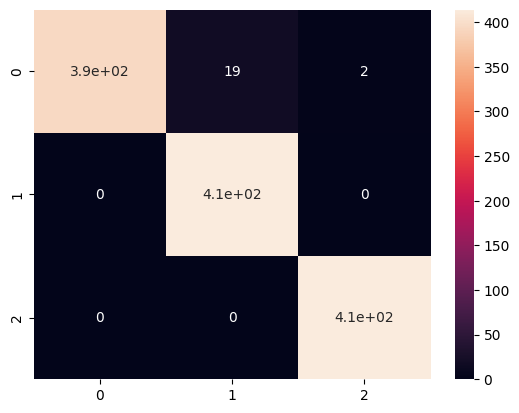

In [27]:
y_pred = knn.predict(X_test)
confusion_knn=confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_knn,annot=True)

In [28]:
print(classification_report(y_test,knn.predict(X_test)))

              precision    recall  f1-score   support

         1.0       1.00      0.95      0.97       414
         2.0       0.96      1.00      0.98       414
         3.0       1.00      1.00      1.00       414

    accuracy                           0.98      1242
   macro avg       0.98      0.98      0.98      1242
weighted avg       0.98      0.98      0.98      1242



<Axes: >

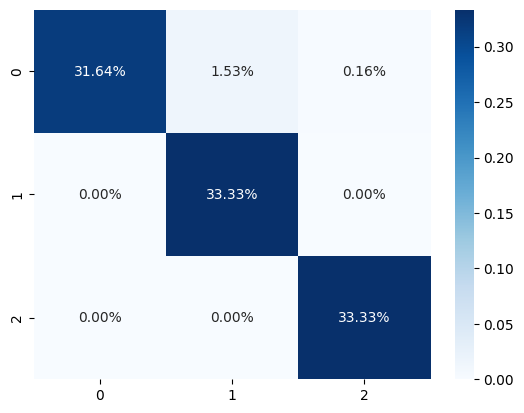

In [29]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

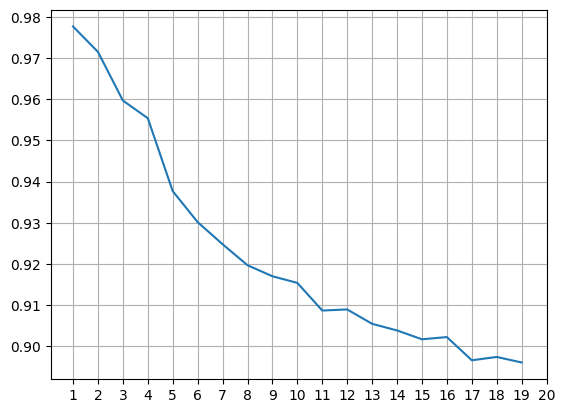

In [30]:
knn_scores=[]
for k in range(1,20):
    knn1=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn1,X_train,y_train,cv=5)
    knn_scores.append(scores.mean())

x_ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
x_labels = x_ticks

plt.plot([k for k in range(1,20)],knn_scores)
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.grid()

In [31]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [32]:
# param_grid={'C':[10,20,30,40,50,100], 'gamma':[10,100,110,120,130,150,200]}
# GridSearchCV_svm=GridSearchCV(SVC(),param_grid,cv=5)
# GridSearchCV_svm.fit(X_train,y_train)
# best_estimator_svm = GridSearchCV_svm.best_estimator_
# best_params_svm = GridSearchCV_svm.best_params_
# best_score_svm = GridSearchCV_svm.best_score_
# best_params_svm

In [33]:
svm=SVC(random_state=42,gamma = 100, C = 100)
svm.fit(X_train,y_train)
y_pred_svm=svm.predict(X_test)

<Axes: >

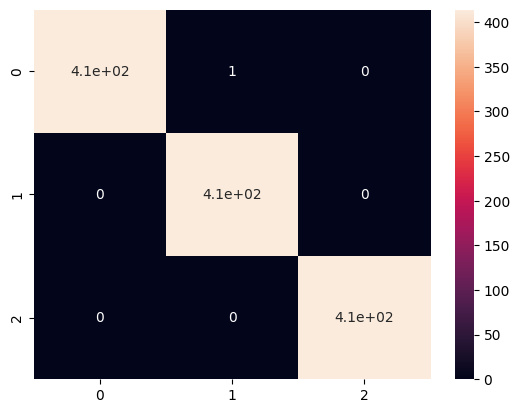

In [34]:
confusion_svm=confusion_matrix(y_test,svm.predict(X_test))
sns.heatmap(confusion_svm,annot=True)

In [35]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       414
         2.0       1.00      1.00      1.00       414
         3.0       1.00      1.00      1.00       414

    accuracy                           1.00      1242
   macro avg       1.00      1.00      1.00      1242
weighted avg       1.00      1.00      1.00      1242



<Axes: >

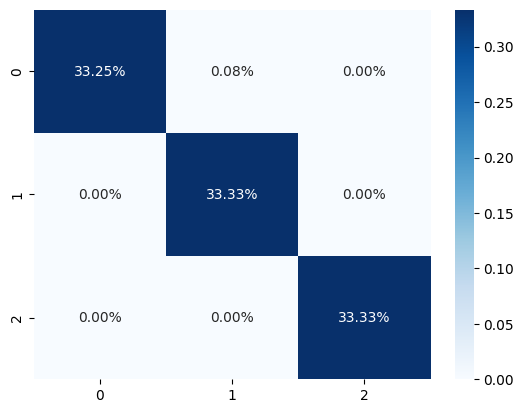

In [36]:
sns.heatmap(confusion_svm/np.sum(confusion_svm), annot=True, fmt='.2%', cmap='Blues')

In [37]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [38]:
# params_dt = {
#     "max_depth": list(range(1,20)),
#     "min_samples_leaf": list(range(1,30)),
#     "min_samples_split": list(range(1,40)),
#               }
# GridSearchCV_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
#                                 param_grid=params_dt,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_dt.fit(X_train, y_train)
# best_estimator_dt = GridSearchCV_dt.best_estimator_
# best_params_dt = GridSearchCV_dt.best_params_
# best_score_dt = GridSearchCV_dt.best_score_
# best_params_dt

In [39]:
dt=DecisionTreeClassifier(random_state=42,min_samples_leaf = 1, min_samples_split= 2, max_depth= 19)
dt.fit(X_train,y_train)
y_pred_dt=dt.predict(X_test)

<Axes: >

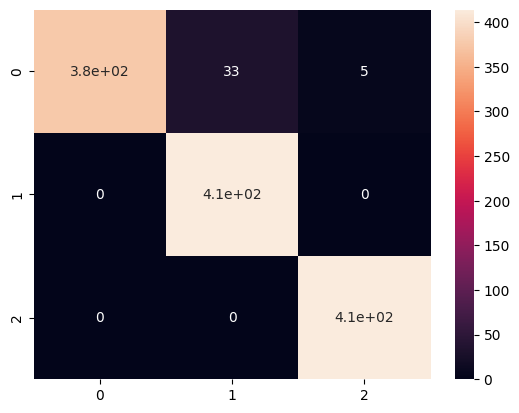

In [40]:
confusion_dt=confusion_matrix(y_test,dt.predict(X_test))
sns.heatmap(confusion_dt,annot=True)

In [41]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95       414
         2.0       0.93      1.00      0.96       414
         3.0       0.99      1.00      0.99       414

    accuracy                           0.97      1242
   macro avg       0.97      0.97      0.97      1242
weighted avg       0.97      0.97      0.97      1242



In [42]:
rf=RandomForestClassifier(random_state=42,min_samples_leaf = 1, min_samples_split= 2, max_depth= 19)
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

<Axes: >

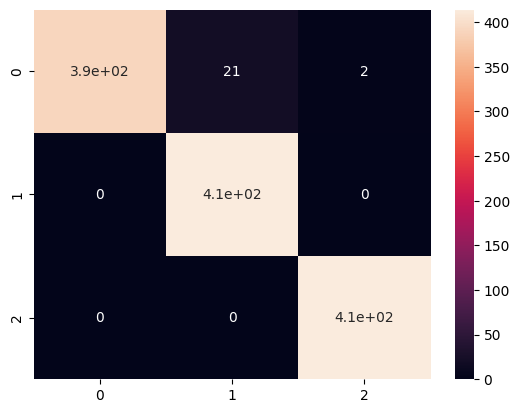

In [43]:
confusion_rf=confusion_matrix(y_test,rf.predict(X_test))
sns.heatmap(confusion_rf,annot=True)

In [44]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97       414
         2.0       0.95      1.00      0.98       414
         3.0       1.00      1.00      1.00       414

    accuracy                           0.98      1242
   macro avg       0.98      0.98      0.98      1242
weighted avg       0.98      0.98      0.98      1242



In [45]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [46]:
#params_gb = {
#     "learning_rate": [0.01,0.1,1,10],
#     'n_estimators': [50, 100, 150, 200],
# #     "max_depth": list(range(1,20)),
# #     "min_samples_leaf": list(range(1,10)),
# #     "min_samples_split": list(range(1,10)),
#               }
# GridSearchCV_gb = GridSearchCV(estimator=GradientBoostingClassifier(),
#                                 param_grid=params_gb,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_gb.fit(X_train, y_train)
# best_estimator_gb = GridSearchCV_gb.best_estimator_
# best_params_gb = GridSearchCV_gb.best_params_
# best_score_gb = GridSearchCV_gb.best_score_
# best_params_gb

In [47]:
gb=GradientBoostingClassifier(random_state=42, learning_rate = 1.0, n_estimators = 50, subsample = 0.8, min_samples_leaf = 1, min_samples_split= 2, max_depth= 19)
gb.fit(X_train,y_train)
y_pred_gb=gb.predict(X_test)

<Axes: >

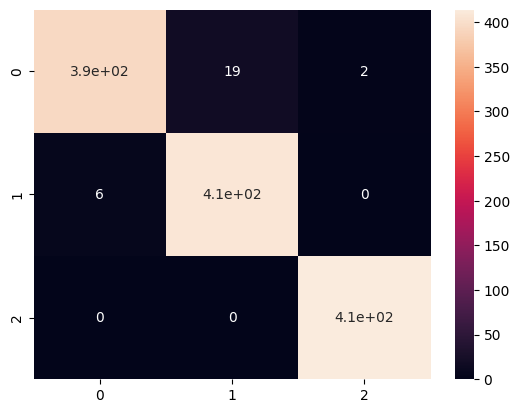

In [48]:
confusion_gb=confusion_matrix(y_test,gb.predict(X_test))
sns.heatmap(confusion_gb,annot=True)

In [49]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95       414
         2.0       0.93      1.00      0.96       414
         3.0       0.99      1.00      0.99       414

    accuracy                           0.97      1242
   macro avg       0.97      0.97      0.97      1242
weighted avg       0.97      0.97      0.97      1242



In [50]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [51]:
# params_xgb = {
#     "learning_rate": [0.01,0.1,1,10],
#               }
# GridSearchCV_xgb = GridSearchCV(estimator=XGBClassifier(),
#                                 param_grid=params_xgb,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_xgb.fit(X_train, y_train)
# best_estimator_xgb = GridSearchCV_xgb.best_estimator_
# best_params_xgb = GridSearchCV_xgb.best_params_
# best_score_xgb = GridSearchCV_xgb.best_score_
# best_params_xgb

In [53]:
y_train_shifted = y_train - 1
xgb.fit(X_train, y_train_shifted)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: >

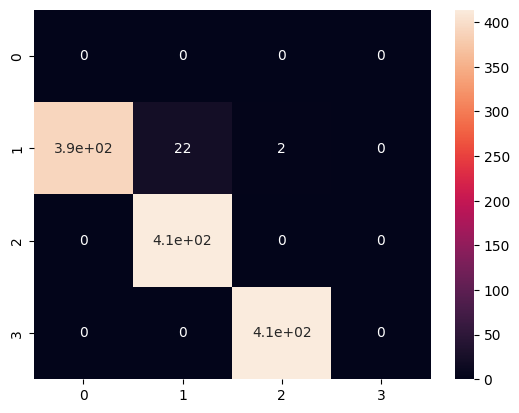

In [54]:
confusion_xgb=confusion_matrix(y_test,xgb.predict(X_test))
sns.heatmap(confusion_xgb,annot=True)

In [55]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95       414
         2.0       0.93      1.00      0.96       414
         3.0       0.99      1.00      0.99       414

    accuracy                           0.97      1242
   macro avg       0.97      0.97      0.97      1242
weighted avg       0.97      0.97      0.97      1242



In [56]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [57]:
# params_ada = {
#     "learning_rate": [1,2,3,4],
#     'n_estimators': [200,250,300],
#               }
# GridSearchCV_ada = GridSearchCV(estimator=AdaBoostClassifier(),
#                                 param_grid=params_ada,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_ada.fit(X_train, y_train)
# best_estimator_ada = GridSearchCV_ada.best_estimator_
# best_params_ada = GridSearchCV_ada.best_params_
# best_score_ada = GridSearchCV_ada.best_score_
# best_params_ada

In [58]:
ada=AdaBoostClassifier(random_state=42, base_estimator = DecisionTreeClassifier(), learning_rate = 1.0, n_estimators=200)
ada.fit(X_train,y_train)
y_pred_ada=ada.predict(X_test)

<Axes: >

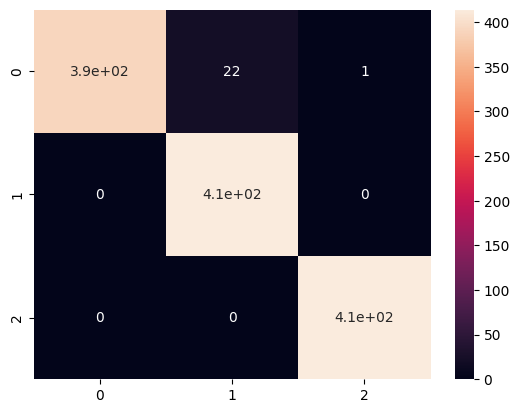

In [59]:
confusion_ada=confusion_matrix(y_test,ada.predict(X_test))
sns.heatmap(confusion_ada,annot=True)

In [60]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95       414
         2.0       0.93      1.00      0.96       414
         3.0       0.99      1.00      0.99       414

    accuracy                           0.97      1242
   macro avg       0.97      0.97      0.97      1242
weighted avg       0.97      0.97      0.97      1242



In [61]:
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [62]:
# loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
# penalty = ['l1', 'l2', 'elasticnet']
# alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
# eta0 = [1, 10, 100]
# params_sgd = dict(loss=loss, penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=eta0)

# GridSearchCV_sgd = GridSearchCV(estimator=SGDClassifier(),
#                                 param_grid=params_sgd,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_sgd.fit(X_train, y_train)
# best_estimator_sgd = GridSearchCV_sgd.best_estimator_
# best_params_sgd = GridSearchCV_sgd.best_params_
# best_score_sgd = GridSearchCV_sgd.best_score_
# best_params_sgd

In [63]:
sgd=SGDClassifier(random_state=42, alpha=0.0001,
                  eta0 = 1, learning_rate='invscaling',
                 loss = 'hinge', penalty = 'elasticnet')
sgd.fit(X_train,y_train)
y_pred_sgd=sgd.predict(X_test)

<Axes: >

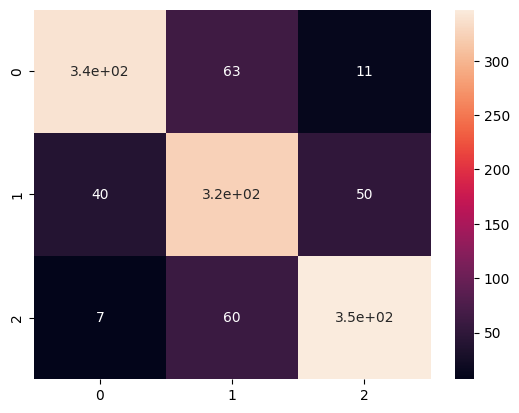

In [64]:
confusion_sgd=confusion_matrix(y_test,sgd.predict(X_test))
sns.heatmap(confusion_sgd,annot=True)

In [65]:
print(classification_report(y_test,y_pred_sgd))

              precision    recall  f1-score   support

         1.0       0.88      0.82      0.85       414
         2.0       0.72      0.78      0.75       414
         3.0       0.85      0.84      0.84       414

    accuracy                           0.81      1242
   macro avg       0.82      0.81      0.82      1242
weighted avg       0.82      0.81      0.82      1242



In [66]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [67]:
# params_lgbm = {
#     "learning_rate": [0.01,0.1,1,10],
#               }
# GridSearchCV_lgbm = GridSearchCV(estimator=LGBMClassifier(),
#                                 param_grid=params_lgbm,
#                                 cv=cv_method,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="accuracy",
#                                 return_train_score=True
#                                 )
# # Fit model with train data
# GridSearchCV_lgbm.fit(X_train, y_train)
# best_estimator_lgbm = GridSearchCV_lgbm.best_estimator_
# best_params_lgbm = GridSearchCV_lgbm.best_params_
# best_score_lgbm = GridSearchCV_lgbm.best_score_
# best_params_lgbm

In [68]:
lgbm=LGBMClassifier(random_state=42, learning_rate = 1.0)
lgbm.fit(X_train,y_train)
y_pred_lgbm=lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3314
[LightGBM] [Info] Number of data points in the train set: 3723, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<Axes: >

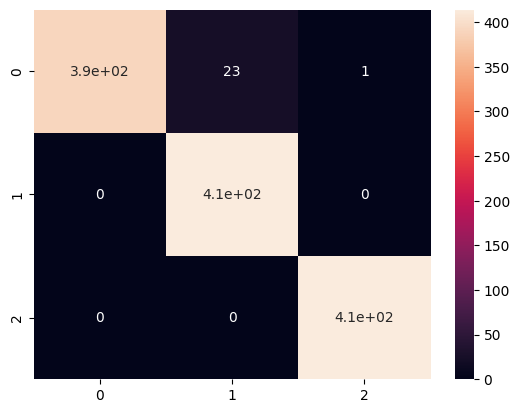

In [69]:
confusion_lgbm=confusion_matrix(y_test,lgbm.predict(X_test))
sns.heatmap(confusion_lgbm,annot=True)

In [70]:
print(classification_report(y_test,y_pred_lgbm))

              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97       414
         2.0       0.95      1.00      0.97       414
         3.0       1.00      1.00      1.00       414

    accuracy                           0.98      1242
   macro avg       0.98      0.98      0.98      1242
weighted avg       0.98      0.98      0.98      1242



In [71]:
print(f"Accuracy of KNN model -> {round(knn.score(X_test, y_test),4)*100}%")
print(f"Accuracy of SVM model -> {round(svm.score(X_test, y_test),3)*100}%")
print(f"Accuracy of RF model -> {round(rf.score(X_test, y_test),4)*100}%")
print(f"Accuracy of DT model -> {round(dt.score(X_test, y_test),4)*100}%")
print(f"Accuracy of GB model -> {round(gb.score(X_test, y_test),3)*100}%")
print(f"Accuracy of XGB model -> {round(xgb.score(X_test, y_test),3)*100}%")
print(f"Accuracy of Ada model -> {round(ada.score(X_test, y_test),3)*100}%")
print(f"Accuracy of SGD model -> {round(sgd.score(X_test, y_test),4)*100}%")
print(f"Accuracy of LGBM model -> {round(lgbm.score(X_test, y_test),3)*100}%")

Accuracy of KNN model -> 98.31%
Accuracy of SVM model -> 99.9%
Accuracy of RF model -> 98.15%
Accuracy of DT model -> 96.94%
Accuracy of GB model -> 97.8%
Accuracy of XGB model -> 1.7999999999999998%
Accuracy of Ada model -> 98.1%
Accuracy of SGD model -> 81.39999999999999%
Accuracy of LGBM model -> 98.1%
